## Jupyter notebook

This is a **jupyter notebook** in which you can mix cells of Python code and cell of markdown.

To execute a code in a `cell` you can click on it and then do one of the following:
 - click on the `Run/Play` button in the toolbar
 - click on the menu `Cell > Run Cells`
 - click on the menu `Help > Keyboard shortcuts` to discover that you can also
 - press `Alt`+`Enter`
 - press `Control`+`Enter`
 
 
Using the menu `Cell > Cell Type` you can change the content of the cell: either *Code*  or *Markdown*, where Markdown is a simple method to format text (https://en.wikipedia.org/wiki/Markdown). Click on the menu `Help > Markdown` to discover how format a text cell.
 
The current cell is a *Markdown* one. To access the original Markdown text, double click on this cell.

To pretty visualize this Markdown cell, you have to follow the same steps illustrated above for a code cell, asking for running the cell.


You can UPLOAD and RUN this and other notebooks by using the Google cloud services. For example, open with Chrome and connect with your stud.unive.it account to:  https://colab.research.google.com


 ## Data collection RCV1

To use directly the *RCV1* collection is needed to buy CD-ROMs from Reuters, Ltd. and sign a research agreement.
However, Reuters have stated that distributing term/document matrices is not a violation of the Agreement.

To ensure that the original data cannot be reconstructed, the term/document matrices distributed are built by removing words from a large stop list (including essentially all linguistic function words), replacing the remaining words with stems, and scrambling the order of the stems.

Specifically, Appendix 12 consists of **ten** ASCII files containing tokenized documents. 

The files fall in two groups, and the names and the group purposes depend on the usage of RCV1 for text classification, a specific machine learning (ML) task. So the files are subdivided in training and test, as usual for ML predictive tasks.

The following five files contains:
 - 23,149 training documents
 - 781,265 test documents
 - total: 804,414 documents
 
This collection of five files, known as RCV1-v2, were used to produce the *vectors* in turn exploited for training and testing supervised learners in LYRL2004. 

The five compressed files are:
  - lyrl2004_tokens_test_pt0.dat.gz : 44,734,992 Bytes - 199,328 documents
  - lyrl2004_tokens_test_pt1.dat.gz : 45,595,102 Bytes - 199,339 documents
  - lyrl2004_tokens_test_pt2.dat.gz : 44,507,510 Bytes - 199,576 documents
  - lyrl2004_tokens_test_pt3.dat.gz : 42,052,117 Bytes - 183,022 documents
  - lyrl2004_tokens_train.dat.gz :    5,108,963  Bytes - 23,149  documents
 
Besides the above files, other tokenized documents are provided. Due to the purpose of this colletion, i.e., to provide a collection for text classification, the authors identified many documents in the original RCV1 documents that had demonstrably invalid category codes. 
The tokenized files are the following:

  - lyrl2004-non-v2_tokens_test_pt0.dat.gz : 149,887 Bytes - 671 documents
  - lyrl2004-non-v2_tokens_test_pt1.dat.gz : 171,205 Bytes - 661 documents
  - lyrl2004-non-v2_tokens_test_pt2.dat.gz : 102,370 Bytes - 424 documents
  - lyrl2004-non-v2_tokens_test_pt3.dat.gz : 132,291 Bytes - 463 documents
  - lyrl2004-non-v2_tokens_train.dat.gz : 46,419 Bytes - 158 documents

for a total number of documents equal to 2,377.

Finally, we have globally the total number of documents of RCV1: 804,414 + 2,377 = 806,791.


### File format

Each document in a file is represented in a format used by the SMART text retrieval system. A document has the format:



      .I <docid>
      .W
      <textline>+
      <blankline>


where:


      <docid> : Reuters-assigned document id. 
      <textline> : A line of white-space separated strings, one for each token 
                   produced by preprocessing for the specified document. 
                   These lines never begin with a period followed by an upper case alphabetic character.
      <blankline> : A single end of line character. 

This is an example of a list of (short) tokenized documents in a given file:

      .I 1
      .W
      now is the time for all good documents
      to come to the aid of the ir community
      
      .I 2
      .W
      i am the best document since i have only one line

      .I 3
      .W
      no i am the best document 


For more detail, see the distribution page: http://www.ai.mit.edu/projects/jmlr/papers/volume5/lewis04a/lyrl2004_rcv1v2_README.htm



[LYRL2004] *Lewis, D. D.; Yang, Y.; Rose, T.; and Li, F. RCV1: A New Benchmark Collection for Text Categorization Research. Journal of Machine Learning Research, 5:361-397, 2004. http://www.jmlr.org/papers/volume5/lewis04a/lewis04a.pdf. *


## SPIMI indexer

In [1]:

from os import walk
import numpy as np

'''
    Download the gzip files from: 
      http://www.ai.mit.edu/projects/jmlr/papers/volume5/lewis04a/lyrl2004_rcv1v2_README.htm
    as follows:
      lyrl2004_tokens_test_pt0.dat.gz : 149887 
      lyrl2004_tokens_test_pt1.dat.gz : 171205
      lyrl2004_tokens_test_pt2.dat.gz : 102370
      lyrl2004_tokens_test_pt3.dat.gz : 132291
      lyrl2004_tokens_train.dat.gz : 46419
      
    I stored the files in the directory "./FILES" and then decompressed by gunzip
'''

files=[]
for (dirpath, dirnames, filenames) in walk("./FILES/"):
    for f in filenames:
        if '.gz' not in f:    # read only the decompressesd files
            files.append(dirpath + f)



'''
    Return a dictionary where the keys are the terms and the values 
    are sorted lists of DocIDs
    The DocID are generated sequentially during the parsing.
'''
def SPIMI_indexer(files):
    dict = {}       # SPIMI (Single-pass in-memory indexing) dictionary 

    docid = 0         # counter to assign docids
    tot_docs = 0      # total number of docs
    tot_tokens = 0    # total number of tokens
    tot_postings = 0  # total number of postings
    
    for f in files:
        print(f)
        count_doc = 0       # number of docs per file .dat     
        count_tokens = 0    # number of tokens per file .dat
        count_postings = 0  # number of postings per file .dat

        try:
            file = open(f, 'r')
            
            # Build dict{} of (key:value) pairs
            # key <-  term
            # value <- a list:  [cf, [doc_i1, doc_i2, doc_i3, ...]]
            #          where cf = collection frequency of the term
            #                [doc_i1, doc_i2, ...] are an integer list of DocIDs, 
            #                                      sorted by construction

            for line in file:
                ll = line.split()

                if len(ll) != 0:
                    if ll[0] == ".I":         # .I 1
                        count_doc = count_doc + 1
                        docid += 1  # assign sequentially the DocIDs
                        # docid = int(ll[1])  #  docid in the collection
                    elif ll[0] != ".W":       #  != .W  :   <textline> 
                        count_tokens += len(ll)
                        for el in ll:
                            if (el in dict):
                                # lenl = len(dict[el][1])     # current len of the posting list
                                dict[el][0] += 1              # increment cf for term el
                                if docid != dict[el][1][-1]:  # check if doc_id was already appended
                                    dict[el][1].append(docid)
                                    count_postings += 1
                            else:
                                dict[el] = [1, [docid]]  
                                           # value for key=el:
                                           #     [cf, [docid1, docid2, ....]]
                                           # df = len([docid1, docid2, ....])
                                count_postings += 1

            file.close()
        except IOError:
            print("File", f, "doesn't exist!")

        print(f, " - docs:", count_doc, "   tokes:", count_tokens)
        tot_docs += count_doc
        tot_tokens += count_tokens
        tot_postings += count_postings
    
    term_df = [(k, len(dict[k][1]), dict[k][0]) for k in dict]  # [(term, df, cf), ...]
    term_df.sort(key=lambda el: el[1], reverse=True)            # sort by df in reverse order
    print(term_df[:100])                                        # 100 terms with the longest posting lists
    print(term_df[-101:-1])                                     # 100 terms with the smallest posting lists
     
    
    print("Total no. of terms (Voc. SZ):", len(dict))
    print("Total no. of tokens:", count_tokens)
    print("Total no. of documents:", tot_docs)
    print("Total no. of postings:", tot_postings)
    return dict

if files != []:
    dict = SPIMI_indexer(files)

./FILES/lyrl2004_tokens_test_pt0.dat
./FILES/lyrl2004_tokens_test_pt0.dat  - docs: 199328    tokes: 24474588
[('year', 86747, 207127), ('million', 69565, 191853), ('percent', 67722, 214479), ('stat', 65312, 118010), ('newsroom', 60537, 60614), ('month', 58139, 96432), ('market', 57013, 140363), ('compan', 54502, 114137), ('trad', 52776, 142435), ('shar', 49871, 137559), ('end', 49292, 80109), ('expect', 47416, 78952), ('offic', 44639, 81926), ('pric', 43842, 108175), ('report', 42951, 69971), ('week', 42710, 79484), ('high', 41767, 78053), ('govern', 40281, 88262), ('bank', 39999, 122967), ('tuesday', 39851, 53065), ('wednesday', 39536, 51965), ('thursday', 38373, 50610), ('billion', 38298, 82718), ('early', 38194, 51035), ('day', 38069, 62721), ('add', 37803, 51531), ('cent', 37510, 77668), ('told', 36477, 48826), ('clos', 36221, 65764), ('sale', 35877, 68551), ('monday', 35876, 48500), ('lead', 35753, 57337), ('time', 35696, 51655), ('friday', 35124, 49008), ('produc', 34670, 69071),

## Store the index on two files

The first file "lexicon.idx" is a text file that contains the vocabulary and the length of the postings list associated with each term (one for line).

The second file "postings.idx" is another text file that contains, one for line, the postings list of each term (a sorted list of integer *docIDs*). 


In [2]:


'''
    dict: dictionary containing for each term (key) 
          a list of docIDs (postings list of integers)
    file_lexicon:  text file containing for each line a term, the collection frequency, and the length of the postings list 
                   associated with the term
    file_postings: text file that contains, one for line, the postings list of each term 
                   (a sorted list of integer docIDs).    
'''
def create_index(dict, file_lexicon, file_postings):
    f1 = open(file_lexicon, "w")
    f2 = open(file_postings, "w")

    index = 0
    voc = list(dict.keys())
    voc.sort()
    for term in voc:
        cf = dict[term][0]       # collection frequency
        df = len(dict[term][1])  # document frequency (to compute idf)
        f1.write("{} {} {} {}\n".format(term, cf, df, index)) # each line: term, cf, df, global_index
        for docid in dict[term][1]:
            f2.write("{} ".format(docid))
        f2.write("\n")
        index = index + len(dict[term][1])
    f1.close()
    f2.close()
    
    

'''
    file_lexicon:  text file containing for each line a term, the collection frequency, the document frequency, and
                   the (text) offset in the postings list file
    file_postings: text file that contains, one for line, the postings list of each term 
                   (a sorted list of integer docIDs).    

    RETURN: a dictionary containing for each term (key) a list of docIDs (postings list of integers)
'''
def read_index(file_lexicon, file_postings):
    i = 1
    try:
        f1 = open(file_lexicon, 'r')
    except IOError:
        print("File", file_lexicon, "doesn't exist!")
    try:
        f2 = open(file_postings, 'r')
    except IOError:
        print("File", file_postings, "doesn't exist!")

    new_dict = {}

    for line_term in f1:
        if i % 1000 == 0:
            print("+", end='', sep='')
        i += 1
        postings = f2.readline()
        l_term = line_term.split() # 4 elements: (1) term, (2) collection frequency, (3) document frequency, 
                                   # and (4) global inxed in the postings list file
        l_postings = postings.split()
        new_dict[l_term[0]] = [int(l_term[1]), [int(el) for el in l_postings]]  # list of integers
        
    f1.close()
    f2.close()
    return(new_dict)
    

create_index(dict, "lexicon.idx", "postings.idx")
dict1 = read_index("lexicon.idx", "postings.idx")


term_df = [(k, len(dict1[k][1]), dict1[k][0]) for k in dict1]
term_df.sort(key=lambda el: el[1], reverse=True) # sort by df in reverse order
print(term_df[:100])  # no stop-words
print(term_df[-101:-1])
    
        


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++[('year', 86747, 207127), ('million', 69565, 191853), ('percent', 67722, 214479), ('stat', 65312, 118010), ('newsroom', 60537, 60614), ('month', 58139, 96432), ('market', 57013, 140363), ('compan', 54502, 114137), ('trad', 52776, 142435), ('shar', 49871, 137559), ('end', 49292, 80109), ('expect', 47416, 78952), ('offic', 44639, 81926), ('pric', 43842, 108175), ('report', 42951, 69971), ('week', 42710, 79484), ('high', 41767, 78053), ('govern', 40281, 88262), ('bank', 39999, 122967), ('tuesday', 39851, 53065), ('wednesday', 39536, 51965), ('thursday', 38373, 50610), ('billion', 38298, 82718), ('early', 38194, 51035), ('day', 38069, 62721), ('add', 37803, 51531), ('cent', 37510, 77668), ('told', 36477, 48826), ('clos', 36221, 65764), ('sale', 35877, 68551), ('monday', 35876, 48500), ('lead', 35753, 57337), ('time', 35696, 51655), ('friday', 35124, 4900

## Plot the distribution of terms vs. frequencies

The terms are sorted by frequencies in reverse order.

Zipf's law:  $cf_i = K \cdot i^{-1}$, where $cf_i$ is the collection frequency of the $i^{th}$ most frequent term.


In *log-log*: $\log(cf_i) = - \log(i) + \log(K)$, which is the equation of a straight line of slope $-1$:  
$$y = -x + \textit{intercept}$$
where $\textit{intercept}$ is the unknown. 

<IPython.core.display.Javascript object>


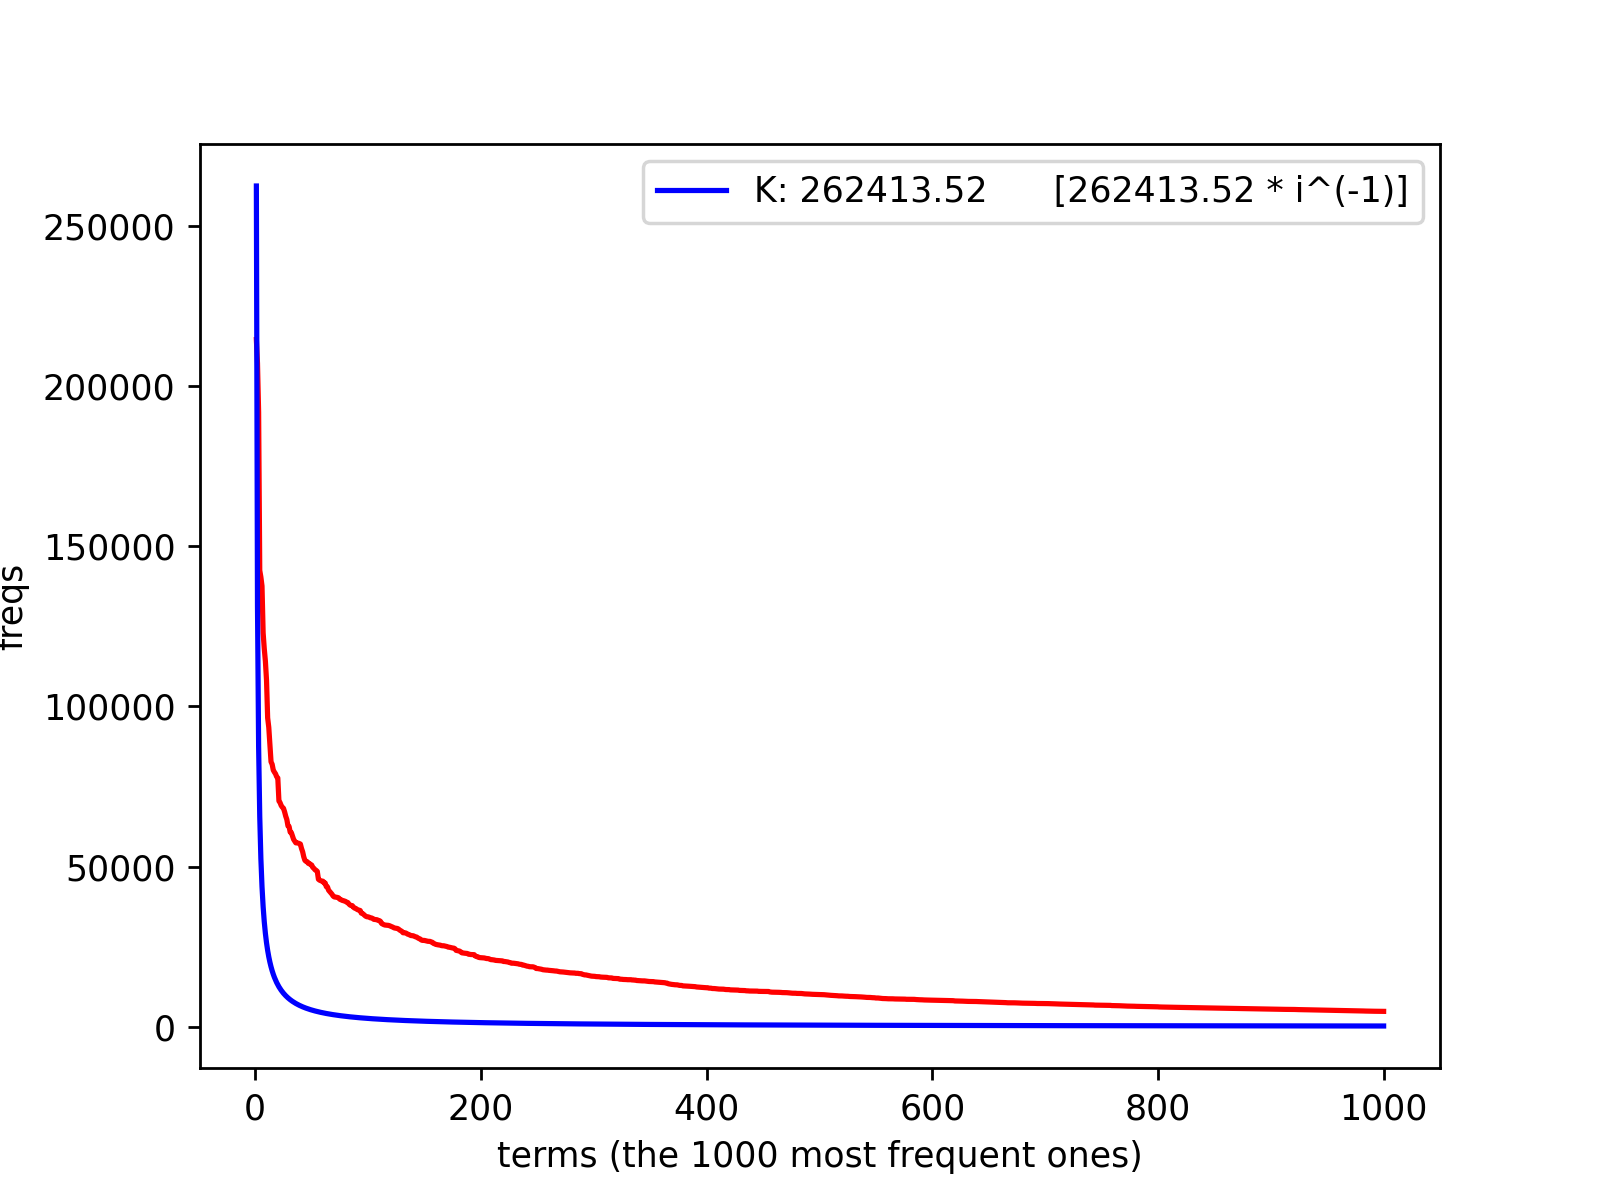

<IPython.core.display.Javascript object>


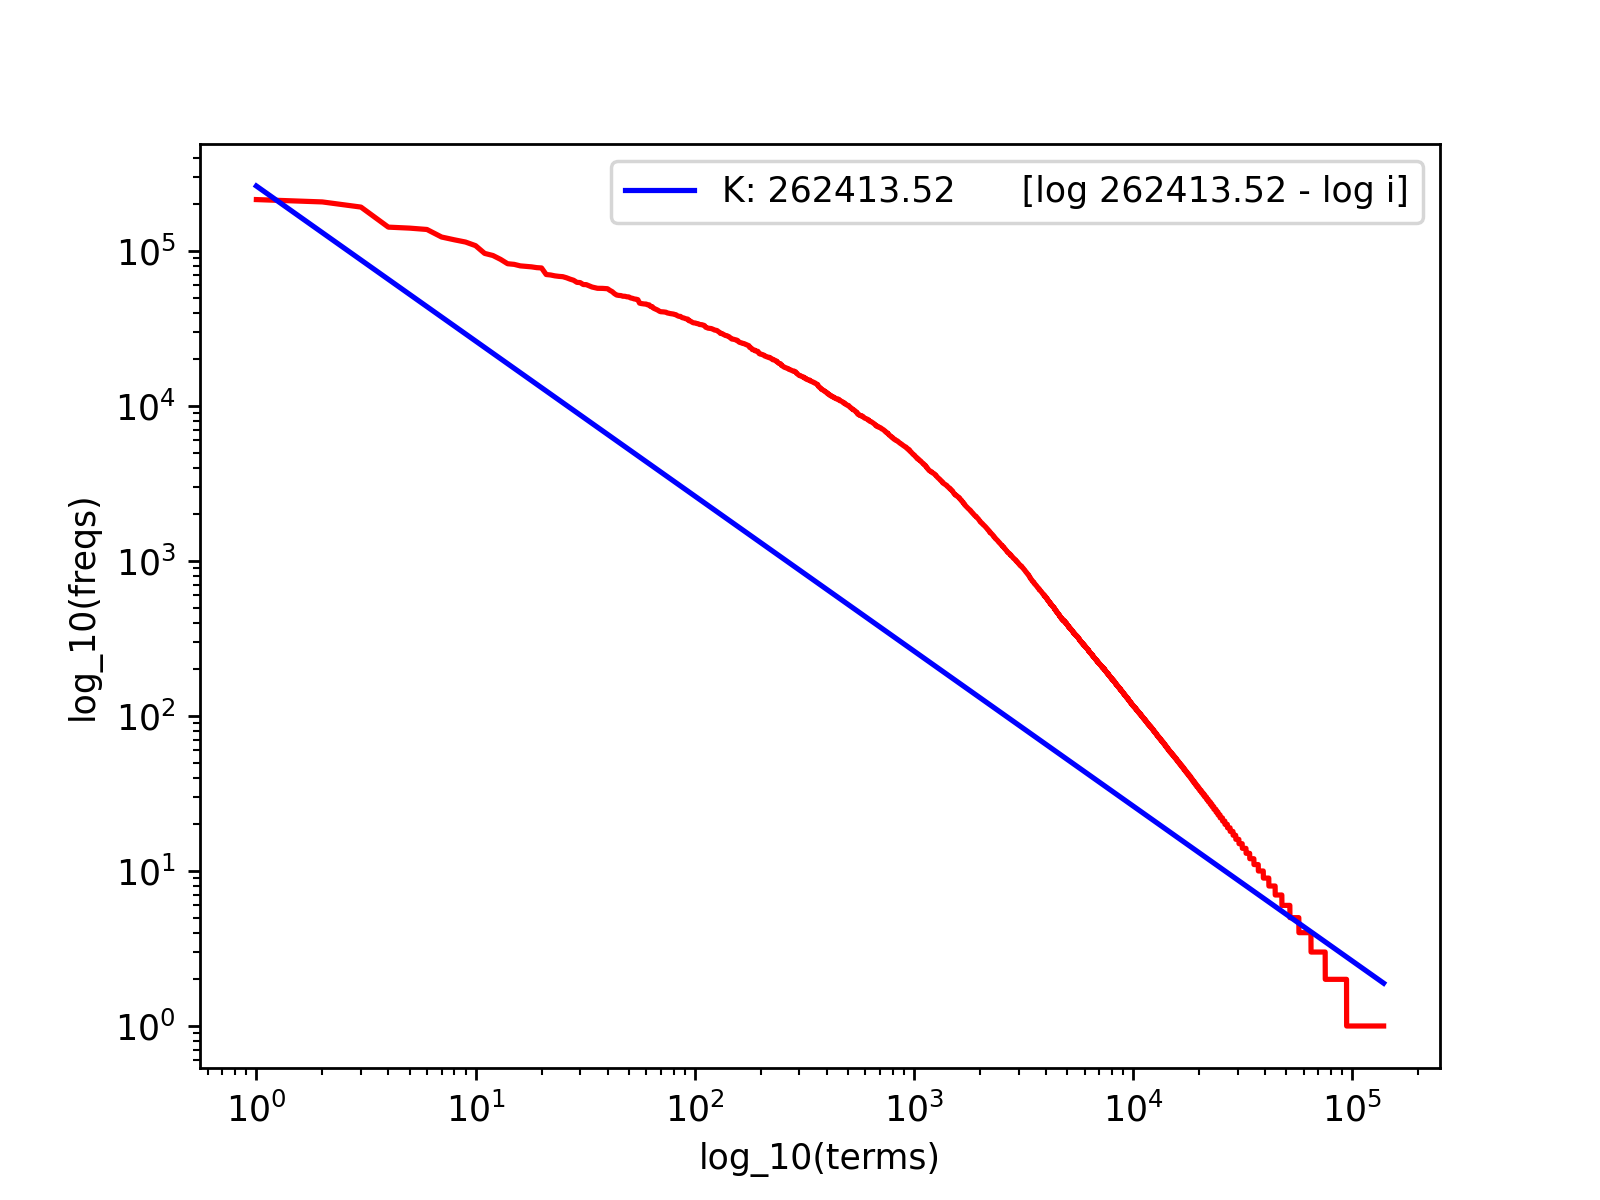

In [3]:
import matplotlib.pyplot as plt 
%matplotlib notebook

import numpy as np


def plot_Zip_law(dict):

    freqs = [int(v[0]) for v in dict.values()]  # take the cf of each vocabulary term 
    freqs.sort(reverse=True)                    # values of Y axis: cf_1, cf_2, cf_3, ....
    x = [i for i in range(1,len(freqs)+1)]      # values of X axis: i = 1, 2, 3, ... 


    # log-log transformation
    x1 = np.log10(x)                    
    y1 = np.log10(freqs)

    
    # Zip law, fixed "slope" of -1 for the straight line in log-log
    slope = -1
    # Y = - X + intercept => 
    # Y + X = intercept
    # For each pair (x1[i], y1[i]), by substituting in the previos equation, we have:  
    #     y1[i] + x1[i] = intercept <= the constant 'intercept' is unknown, and thus differ for 
    # each pair (x1[i], y1[i]) 
    
    # To fit the straight line  Y = - X + intercept, determine the "intercept" by averaging among all 
    # pairs (x1[i], y1[i]) for all i:  
    intercept = np.mean(y1 + x1)   # intercept = log(K) (in log.log)

    # 10^(log10(cf)) = 10^(-log10(i) + intercept)
    # cf = 10^(-log10(i)) * 10^(intercept)
    # cf = -i * 10^(intercept)
    fitted_f = [(elx**slope) * (10**intercept) for elx in x]
    

    # plot the long tail, without log/log transformation
    plt.figure(1)
    plt.xlabel('terms (the 1000 most frequent ones)')
    plt.ylabel('freqs')
    lab = 'K: %.2f' % (10**intercept) + '      [' + '%.2f' % (10**intercept) + ' * i^(-1)]'
    plt.plot(x[:1000], freqs[:1000], 'r')
    plt.plot(x[:1000], fitted_f[:1000], 'b', label=lab)
    plt.legend()
    plt.show()

    # plot the same figure in log.log
    plt.figure(2)
    plt.xlabel('log_10(terms)')
    plt.ylabel('log_10(freqs)')
    lab = 'K: %.2f' % (10**intercept) + '      [' + 'log %.2f' % (10**intercept) + ' - log i]'
    plt.loglog(x, freqs, 'r')
    plt.loglog(x, fitted_f, 'b', label=lab)
    plt.legend()
    plt.show()


    
plot_Zip_law(dict)




# Clustering documents to compress inverted index

How can we assign document identifiers (**DocIDs**) to the collection's documents for better compressing an inverted file index? 

A popular idea is to perform a clustering on the document collection and assign **close DocIDs** to **similar documents**. 

A technique proposed in the literature is based on the travelling salesman problem (TSP). The heuristic computes a *pairwise distance* between every pairs of documents (proportional to the number of shared terms, e.g., **Jaccard distance** = *1 - JaccardSim*), and then finds the shorthed path traversing the documents in the graph. The suboptimal cycle found is ﬁnally broken at somepoint, and the DocIDs are reassigned to the documents according to the ordering established by the cycle. 
The rationale is that since the cycle preferably traverses edges connecting documents sharing a lot of terms (characterized by a small Jaccard distance), if we assign close DocIDs to these documents, we  expect a reduction in the average value of *d-gaps*, and thus in the size of the compressed inverted index

However, this TSP approach doesn't scale.

To re-assign DocIDs to documents, I suggest the following heuristic method, which at the end exploits TSP to reorder clusters (rather than single documents).
The clustering algorithm scan linearly the documents, sorted in reverse order of length.
Each cluster returned is identified by a **medoid**, which should be a document (belonging to a cluster) that represents all the others in the cluster - i.e., the medoid should be the most centrally located point in the cluster.
However, the  stream clustering algorithm does not guarantee this property of medoids.

1. Transform each document into a **set of termIDs** 
2. Reorder the collection according to the document length (in reverse order) and scan linearly the collection of document to clustering them using the **Jaccard distance** = **1 - JaccardSim**: 
<br> `C = Stream_cluster(SortedCollection, Radius)`<br>
where C is the returned set of clusters, where a document within each cluster is its Medoid.
4. Apply TSP to the Medoids of each cluster, using the *Jaccard distances* between each pair of Medoids
5. Assign the DocIds linearly *cluster by cluster*, using the TSP-induced order. Within each cluster the order is arbitrary.
6. For each **postings list**, reassign the docIDs, compute the *d-gaps*, and determine the total size of all postings lists. It is not needed to materialize the compressed posting lists, but it suffices to determine the **average bits per d-gap**.

The hyperparameter `Radius` is the maximum distance of each document assigned to a cluster from its medoid. If we reduce the radius of clusters, the cardinality of *C* increases, as the collection is partitioned in more clusters. Increasing *|C|*, the computational time increases as well.
Note that a radius of 1 is the maximum possible distance in terms of **Jaccard distance**, and it occurs when two documents don't have any terms in common. 

The pseudo-code of the stream algorithm that visits each document only once is the following:

```
Stream_cluster(SortedCollection, Radius)`
     C = EmptySet
     for each d in SortedCollection
         Dist_c = Min (JaccardDistance(c, d), for each medoid c in C)
         if (Dist_c < radius) then
             add d to cluster c
         else
             make d a new medoid, and add this singleton cluster to C 
     return C
```

An alternative version with two scans, which is a tradeoff betwwen the capability of generating more clusters and the associated computational burden, is the following:
```
    inizialize Radius1 and Radius2, where Radius1 > Radius2 
 
    C = EmptySet
	C_tmp = Stream_cluster(SortedCollection, Radius1)
	foreach c in C_tmp:
		C_c = Stream_cluster(c, Radius2)
        C = C setunion C_c 
```
The method produces a sort of hierarchical cluster, even if at the end it generates a flat clustering `C`, on whose medoids we apply TSP.










